In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ML-LaDECO/LaDECO

/content/drive/MyDrive/ML-LaDECO/LaDECO


In [ ]:
import tensorflow as tf
print('TensorFlow Version',tf.__version__)

TensorFlow Version 2.8.0


In [ ]:
import numpy as np

print('Project MLaDECO')
print('Author: Viswambhar Yasa')
print('Software version: 0.1')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import models
from thermograms.Utilities import Utilities
from ml_training.dataset_generation.fourier_transformation import fourier_transformation
from ml_training.dataset_generation.principal_componant_analysis import principal_componant_analysis
from utilites.segmentation_colormap_anno import segmentation_colormap_anno
from utilites.tolerance_maks_gen import tolerance_predicted_mask
import matplotlib.pyplot as plt

Project MLaDECO
Author: Viswambhar Yasa
Software version: 0.1
1


In [ ]:
root_path = r'utilites/datasets'
data_file_name = r'Variantenvergleich_data.hdf5'
thermal_class = Utilities()
thermal_data,experiment_list=thermal_class.open_file(root_path, data_file_name,True)
experiment_name=r'2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 0°'
experimental_data=thermal_data[experiment_name] 

Experiments in the file 

1  :  2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 0°
2  :  2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 30°
3  :  2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 45°
4  :  2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 0°
5  :  2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 30°
6  :  2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 45°
7  :  2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 10s
8  :  2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 2s
9  :  2021-05-25 - Variantenvergleich - VarioTherm Halogenlampe - Belichtungszeit 5s


A total of 9 experiments are loaded in file  



In [ ]:
input_data, reflection_st_index, reflection_end_index = fourier_transformation(experimental_data,
                                                                               scaling_type='normalization', index=1)

reflection_start_index:  212   reflection_end_index:  738
The size of filtered data: (255, 256, 526)


In [ ]:
from ml_training.dataset_generation.data_preprocessing import data_preprocessing1

In [ ]:
#from data_train_test import data_preprocessing
#from data_train_test import data_preprocessing
dataset_genertor=data_preprocessing1()

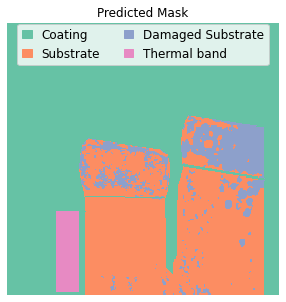

In [ ]:
from utilites.segmentation_colormap_anno import segmentation_colormap_anno
combined_mask=np.load('ml_training/dataset_generation/annots/2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 0°.npy')
segmentation_colormap_anno(combined_mask, heatmap='RdYlBu_r', file_name='seg_mask', disp=True)


In [ ]:
annotation_path=r'ml_training/dataset_generation/annots//'
train_ds,valid_ds,test_ds=dataset_genertor.load_image_segmentation_dataset(thermal_data,experiment_list,annotation_path,save=True)

2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 0°
217 738
(255, 256, 521)
filtered dataset shape : (256, 256, 521) Shape after concatenation : (256, 256, 521)
2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 30°
270 675
(255, 256, 405)
filtered dataset shape : (256, 256, 405) Shape after concatenation : (256, 256, 926)
2021-05-11 - Variantenvergleich - VarioTherm Halogenlampe - Winkel 45°
162 728
(255, 256, 566)
filtered dataset shape : (256, 256, 566) Shape after concatenation : (256, 256, 1492)
2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 0°
93 610
(255, 256, 517)
filtered dataset shape : (256, 256, 517) Shape after concatenation : (256, 256, 2009)
2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 30°
143 660
(255, 256, 517)
filtered dataset shape : (256, 256, 517) Shape after concatenation : (256, 256, 2526)
2021-05-11 - Variantenvergleich - VarioTherm IR-Strahler - Winkel 45°
151 665
(255, 256, 514)
filtered

In [ ]:
train_dataset=dataset_genertor.create_dataset(train_ds[0], train_ds[1])
valid_dataset=dataset_genertor.create_dataset(np.array(valid_ds[0]), valid_ds[1])
test_dataset=dataset_genertor.create_dataset(test_ds[0], test_ds[1])

In [ ]:
repeated_ds=train_dataset.repeat(6)
len(repeated_ds),len(train_dataset)

(16608, 2768)

In [ ]:
from ml_training.dataset_generation.principal_componant_analysis import Augment

In [ ]:
tf.data.experimental.enable_debug_mode()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
aug_train_ds = repeated_ds.map(lambda img,msk: Augment((img,msk)), num_parallel_calls=AUTOTUNE)
aug_test_ds = test_dataset.map(lambda img,msk: Augment((img,msk)), num_parallel_calls=AUTOTUNE)

In [ ]:
batch_size=8

In [ ]:
training_dataset = aug_train_ds.batch(batch_size)
#training_dataset=aug_train_ds.batch(batch_size)
validation_dataset=valid_dataset.batch(batch_size)
#validation_dataset = new_validation_dataset.batch(batch_size)
test_dataset = aug_test_ds.batch(batch_size)
len(train_dataset),len(validation_dataset),len(test_dataset)

(2768, 104, 45)

Text(0.5, 1.0, 'Expected Mask')

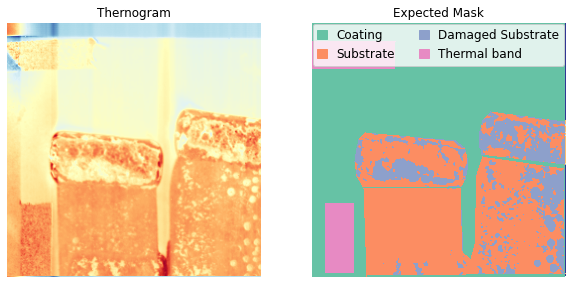

In [ ]:
import seaborn as sns
from matplotlib.patches import Patch
data=next(iter(training_dataset))
i=5
image=data[0][i]
plots_image=np.squeeze(image)
true_anno=data[1][i]
anno1=np.zeros((256,256))
for i in range(4):
  temp=true_anno[:,:,i]
  anno1[temp==1]+=i
fig = plt.figure(figsize=(10, 7))
  
fig.add_subplot(1, 2, 1)
# showing image
plt.imshow(np.squeeze(image),cmap='RdYlBu_r')
plt.axis('off')
plt.title("Thernogram")
  

fig.add_subplot(1, 2, 2)
cmap = sns.mpl_palette("Set2", 4)
c=sns.heatmap(data=anno1, cmap=cmap, cbar=False)
plt.axis('off')

legend_handles = [Patch(color=cmap[0], label='Coating'),  # red
                  Patch(color=cmap[1], label='Substrate'),
                  Patch(color=cmap[2], label='Damaged Substrate'),
                  Patch(color=cmap[3], label='Thermal band')]  # green
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='upper center', fontsize=12, handlelength=.8)
fig = c.get_figure()
# showing image
plt.imshow(anno1,cmap='RdYlBu_r')
#plt.axis('off')
plt.title("Expected Mask")

In [ ]:
from therml.ml_models import PSP_Net

In [ ]:
PSP=PSP_Net()
#FCN_segmentation=FC.FCN_decoder(weights_path='/content/pre_trained_vgg_weights.h5')
PSP_segmentation=PSP.create_model(disp=True)

Building PSP-NET model 

Input shape : (None, 256, 256, 1)
feature_map shape : (None, 256, 256, 128)
block_1 shape : (None, 256, 256, 64)
block_2 shape : (None, 256, 256, 64)
block_3 shape : (None, 256, 256, 64)
block_4 shape : (None, 256, 256, 64)
pyramid map shape : (None, 256, 256, 384)
output shape (None, 256, 256, 4) 

Model built sucessfully 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 Layer1_A (Conv2D)              (None, 256, 256, 16  32          ['input[0][0]']                  
                                )    

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
callbacks=[rlronp, estop]

In [ ]:
from datetime import datetime
import math

def step_decay(epoch):
	initial_lrate = 0.05
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [ ]:
PSP_segmentation.compile(loss=tf.keras.losses.categorical_crossentropy,
    #loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1E-3),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4),
              'accuracy'])

In [ ]:
model_history = PSP_segmentation.fit(training_dataset,batch_size=64,epochs=len(training_dataset),steps_per_epoch=1,verbose=1,shuffle=True,
                                        validation_data=validation_dataset,validation_batch_size=8,validation_steps=1,
                                        callbacks=callbacks)

Epoch 1/2076
1/1 [==============================] - 11s 11s/step - loss: 1.6882 - mean_io_u_1: 0.3750 - accuracy: 0.2667 - val_loss: 2.3385 - val_mean_io_u_1: 0.3750 - val_accuracy: 0.5712 - lr: 0.0010
Epoch 2/2076
1/1 [==============================] - 1s 1s/step - loss: 1.2333 - mean_io_u_1: 0.3750 - accuracy: 0.5014 - val_loss: 5.1682 - val_mean_io_u_1: 0.3759 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 3/2076
1/1 [==============================] - 1s 1s/step - loss: 1.1607 - mean_io_u_1: 0.3750 - accuracy: 0.5742 - val_loss: 6.6477 - val_mean_io_u_1: 0.4126 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 4/2076
1/1 [==============================] - 1s 1s/step - loss: 1.0588 - mean_io_u_1: 0.3750 - accuracy: 0.6849 - val_loss: 7.5083 - val_mean_io_u_1: 0.4248 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 5/2076
1/1 [==============================] - 1s 1s/step - loss: 1.0099 - mean_io_u_1: 0.3750 - accuracy: 0.7054 - val_loss: 7.8153 - val_mean_io_u_1: 0.4175 - val_accuracy: 0.5719 - lr: 0.001

In [ ]:
model_para=model_history.history
path=r'trained_models\PSP\model_history\\'

In [ ]:
filename="PSP.pkl"
file_path=path+filename
import pickle

# define dictionary

# create a binary pickle file 
f = open(file_path,"wb")

# write the python object (dict) to pickle file
pickle.dump(model_para,f)
# close file
f.close()

In [ ]:
PSP_segmentation.evaluate(validation_dataset)

104/104 [==============================] - 19s 178ms/step - loss: 2.2536 - mean_io_u_1: 0.3750 - accuracy: 0.5715


[2.2535669803619385, 0.375, 0.5715160965919495]

In [ ]:
PSP_segmentation.evaluate(test_dataset)

45/45 [==============================] - 14s 283ms/step - loss: 2.2242 - mean_io_u_1: 0.3750 - accuracy: 0.5721


[2.224179983139038, 0.3750000298023224, 0.5721162557601929]

In [ ]:
model_save_path=r'trained_models\PSP\'

In [ ]:
model_name=r'PSP.h5'
model_path=model_save_path+model_name
PSP_segmentation.save(model_path,overwrite=False)

In [ ]:
saved_model_path=r'/content/drive/MyDrive/ML-LaDECO/LaDECO/trained_models/PSP/PSP_adam_seg_16_01_model.h5'

In [ ]:
PS_net=tf.keras.models.load_model(saved_model_path)

In [ ]:
input_image=tf.expand_dims(image,axis=0)
testdata=next(iter(test_dataset))
predict=PS_net.predict_on_batch(testdata[0])
predict.shape

(8, 256, 256, 4)

In [ ]:
input_image=tf.expand_dims(image,axis=0)
testdata=next(iter(test_dataset))
predict=PSP_segmentation.predict_on_batch(testdata[0])
predict.shape

(64, 256, 256, 4)

In [ ]:
i=5
predicted=predict[i,:,:,:]
image=testdata[0][i]
predicted_anno=testdata[1][i]
anno=np.zeros((256,256))
for i in range(4):
  temp=predicted_anno[:,:,i].numpy()
  anno[temp==1]+=i

predicted[predicted>0.5]=1
predicted[predicted<0.5]=0
predicted=np.squeeze(predicted)
pre_anno=np.zeros((256,256))
for i in range(4):
  temp=predicted[:,:,i]
  pre_anno[temp==1]+=i

Text(0.5, 1.0, 'Predicted Mask')

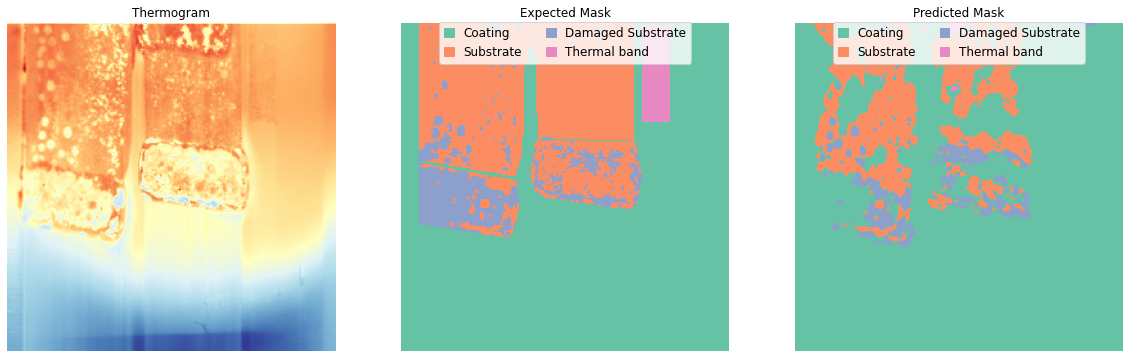

In [ ]:
import seaborn as sns
from matplotlib.patches import Patch

fig = plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
# showing image
plt.imshow(np.squeeze(image),cmap='RdYlBu_r')
plt.axis('off')
plt.title("Thermogram")

fig.add_subplot(1, 3, 2)
cmap = sns.mpl_palette("Set2", 4)
c=sns.heatmap(data=anno, cmap=cmap, cbar=False)
plt.axis('off')
legend_handles = [Patch(color=cmap[0], label='Coating'),  # red
                  Patch(color=cmap[1], label='Substrate'),
                  Patch(color=cmap[2], label='Damaged Substrate'),
                  Patch(color=cmap[3], label='Thermal band')]  # green
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='upper center', fontsize=12, handlelength=.8)
fig = c.get_figure()
plt.imshow(anno1,cmap='RdYlBu_r')
plt.axis('off')
plt.title("Expected Mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(1, 3, 3)
cmap = sns.mpl_palette("Set2", 4)
c=sns.heatmap(data=pre_anno, cmap=cmap, cbar=False)
plt.axis('off')
legend_handles = [Patch(color=cmap[0], label='Coating'),  # red
                  Patch(color=cmap[1], label='Substrate'),
                  Patch(color=cmap[2], label='Damaged Substrate'),
                  Patch(color=cmap[3], label='Thermal band')]  # green
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='upper center', fontsize=12, handlelength=.8)
fig = c.get_figure()

plt.imshow(pre_anno,cmap='RdYlBu_r')
plt.title("Predicted Mask")
#plt.savefig("Documents/U_net_train_prediction.png",dpi=100,bbox_inches='tight',transparent=True)